<h1> Main.ipynb </h1>
<h2> 1. Import libraries and modules </h2>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import yfinance as yf

from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

from Data_Retriever import DataRetriever as DatRet
from Markowitz_PT import MarkowitzPT as MPT

from Menchero_OGA import MencheroOGA as MOGA
from RL_Algorithm.ThesisEnvironment import PortfolioEnvironment as PorEnv
from RL_Algorithm.ThesisModel import RL_Model as RLM

<h2> 2. Define operating variables </h2>

In [2]:
# Define necessary non-fixed variables
trading_n = 30
history_usage = 100
n_sectors = 5
n_stocks_per_sector = 4

<h2> 3. Define stock dataframe </h2>

In [3]:
# Defining stock pool
ticker_df =  pd.DataFrame()
ticker_df["Petroleum"] = ["EQNR.OL", "AKRBP.OL", "SUBC.OL", "BWO.OL",]
ticker_df["Seafood (food)"] = ["ORK.OL", "MOWI.OL", "SALM.OL", "LSG.OL"]
# ticker_df["Materials"] = ["NHY.OL", "YAR.OL", "RECSI.OL", "BRG.OL"]
ticker_df["Technologies"] = ["TEL.OL", "NOD.OL", "ATEA.OL", "BOUV.OL"]
ticker_df["Financial"] = ["STB.OL", "DNB.OL", "GJF.OL", "AKER.OL"]
ticker_df["Shipping"] = ["WAWI.OL", "SNI.OL", "BELCO.OL", "ODF.OL"]
ticker_df

,Petroleum,Seafood (food),Technologies,Financial,Shipping
0,EQNR.OL,ORK.OL,TEL.OL,STB.OL,WAWI.OL
1,AKRBP.OL,MOWI.OL,NOD.OL,DNB.OL,SNI.OL
2,SUBC.OL,SALM.OL,ATEA.OL,GJF.OL,BELCO.OL
3,BWO.OL,LSG.OL,BOUV.OL,AKER.OL,ODF.OL


<h2> 4. Define ESG array </h2>

In [4]:
# Defining ESG scores for respective securities
esg_scores = [36.6, 35.3, 17.9, 18, 
              18, 21.2, 18.7, 29.2, 
            #   15.7, 25.6, 25.6, 18.4, 
              19.8, 13.8, 18.1, 19, 
              17.2, 14, 17.2, 19.5, 
              19.7, 21.2, 26.8, 19.3]

<h2> 5.-7. (Non-necessary for reproducability) </h2>
<h3>Data retrieval</h3>
<h3>Benchmark optimization (MPT)</h3>
<h3>RL optimization</h3>
<br>
All of the data has been generated an stored in csvs

In [15]:
# # Retrieve data from yf API: y-m-d
# data = DatRet(ticker_df, "2013-01-01", "2024-01-01")
# # In function below, set log=True to check for data availability
# data.retrieve_data()

# # Generate benchmark weights thorugh MPT using Sharpe ratio
# benchmark = MPT(history_usage, trading_n)
# # IMPORTANT: In order to see  the effect of the weights, algo exclude last observation from optimization
# benchmark.frequency_optimizing()

# reinforcement = RLM(esg_scores)
# reinforcement.train_model()
# reinforcement.test_model()

<h2> 8. Attribution analysis </h2>

In [8]:
# Portfolio performance attribution analysis
analysis = MOGA(n_sectors, n_stocks_per_sector)

# Frequency analysis
analysis.frequency_analyser()

--Frequency analysis performed succesfully--


<h2> 9. Ad-hoc Analysis </h2>

In [10]:
ew = pd.read_csv("../Data/RL_weights.csv")
bw = pd.read_csv("../Data/MPT_weights.csv")
ret = pd.read_csv("../Data/StockReturns.csv")

In [11]:
exper_w = [ew.iloc[-trading_n+time,:] for time in range(trading_n)]
bench_w = [bw.iloc[-trading_n+time] for time in range(trading_n)]
returns = np.array([ret.iloc[-trading_n+time] for time in range(trading_n)])+1

exper_returns = np.cumprod([np.dot(exper_w[i],returns[i]) for i in range(len(exper_w))])
bench_returns = np.cumprod([np.dot(bench_w[i],returns[i]) for i in range(len(bench_w))])

port_all = analysis.allocation_effects.reshape(-1,n_sectors)
port_all_prod = [np.prod(port_all[i]+1) for i in range(len(port_all))]
port_sel = analysis.selection_effects.reshape(-1,n_sectors)
port_sel_prod = [np.prod(port_sel[i]+1) for i in range(len(port_sel))]
active_return = np.cumprod([port_sel_prod[i]*port_all_prod[i] for i in range(trading_n)])

average_esg = [exper_w[i]@esg_scores for i in range(trading_n)]

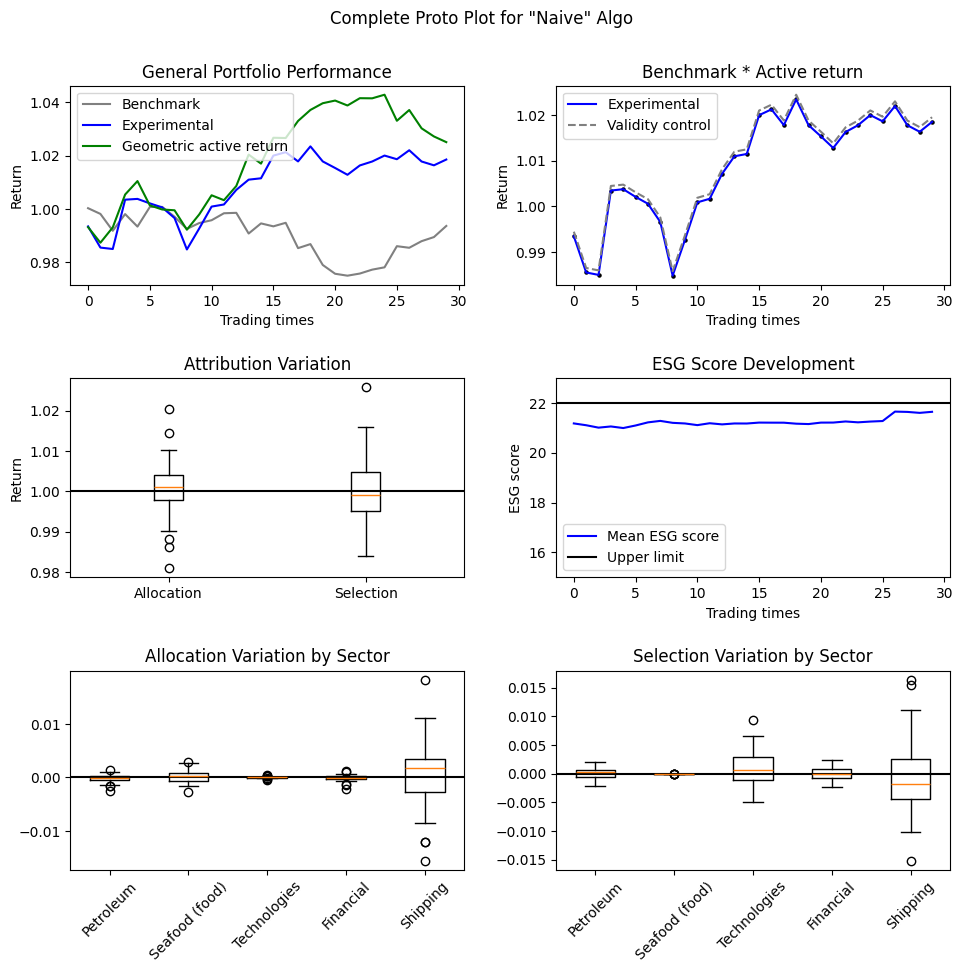

In [12]:
bigfig, ax = plt.subplots(3,2,figsize=(10,10))
ax[0,0].plot(bench_returns, color="grey", label="Benchmark")
ax[0,0].plot(exper_returns, color="blue", label="Experimental")
ax[0,0].plot(active_return, color="green", label= "Geometric active return")
ax[0,0].set_ylabel("Return")
ax[0,0].set_xlabel("Trading times")
ax[0,0].set_title('General Portfolio Performance')
ax[0,0].legend()

ax[0,1].plot(exper_returns, color="blue", label="Experimental")
ax[0,1].scatter(x=np.linspace(0,trading_n-1,trading_n), y =(bench_returns*active_return), s=5, color="black")
ax[0,1].plot((bench_returns*active_return)+(0.001*(bench_returns*active_return)), 
             color="grey", linestyle="--", label="Validity control")
ax[0,1].set_ylabel("Return")
ax[0,1].set_xlabel("Trading times")
ax[0,1].set_title('Benchmark * Active return')
ax[0,1].legend()

data_arrays = [port_all_prod, port_sel_prod]
data_labels = ["Allocation", "Selection"]
ax[1,0].boxplot(data_arrays, tick_labels=data_labels)
ax[1,0].axhline(y=1, color="black")
ax[1,0].set_ylabel("Return")
ax[1,0].set_title('Attribution Variation')

ax[1,1].plot(average_esg, color="blue", label="Mean ESG score")
ax[1,1].axhline(y=22, color='black', linestyle='-', label="Upper limit")  
ax[1,1].set_ylim(15,23)
ax[1,1].set_ylabel("ESG score")
ax[1,1].set_xlabel("Trading times")
ax[1, 1].set_title('ESG Score Development')
ax[1,1].legend()

ax[2,0].boxplot(port_all)
ax[2,0].axhline(y=0, color="black")
ax[2,0].set_xticklabels(ticker_df.columns, rotation=45) 
ax[2,0].set_title('Allocation Variation by Sector')

ax[2,1].boxplot(port_sel)
ax[2,1].axhline(y=0, color="black")
ax[2,1].set_xticklabels(ticker_df.columns, rotation=45) 
ax[2,1].set_title('Selection Variation by Sector')

plt.suptitle('Complete Proto Plot for "Naive" Algo', fontsize=12)
bigfig.tight_layout(pad=2.0)
plt.show()
# plt.close()
